## Isolation Forest Model for Credit Card Fraud Detection

In [2]:
## Logger configuration
from loguru import logger

logger.remove()

logger.add("logs/ocsvm.log",
           level = "DEBUG",
           format = "{time:HH:mm:ss} | {level} | {message}")

1

## Load and Sample Data

In [9]:
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_csv("../creditcard.csv")

df_sampled, _ = train_test_split(df, 
                                test_size = 0.5, 
                                stratify = df['Class'], 
                                random_state = 42)

print(df_sampled.shape)

(142403, 31)


## Split and Scale Data

In [22]:
from sklearn.preprocessing import StandardScaler

# Split the data into features 'X' and target 'y'
target_feature = "Class"
input_features = list(df.columns)
input_features.remove(target_feature)

X = df[input_features]
y = df[target_feature]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Save some unscaled features for later 
X_test_orig = X_test.copy()

# Apply data scaling to unscaled features
scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

## Create and Train Model

- [SKLearn - IsolationForest Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [11]:
from sklearn.ensemble import IsolationForest

# Calculate contamination rate (fraud rate)
contamination_rate = y_train.sum() / len(y_train) 

params = {"n_estimators": 100, 
          "contamination": contamination_rate, 
          "random_state": 42} 

model = IsolationForest(**params, n_jobs = -1)
model.fit(X_train)

# Anomaly score, lower is more anomalous
y_pred_scores = model.decision_function(X_test)  
y_pred = model.predict(X_test)                   

# -1 for anomaly, 1 for normal
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

## Model Evaluation

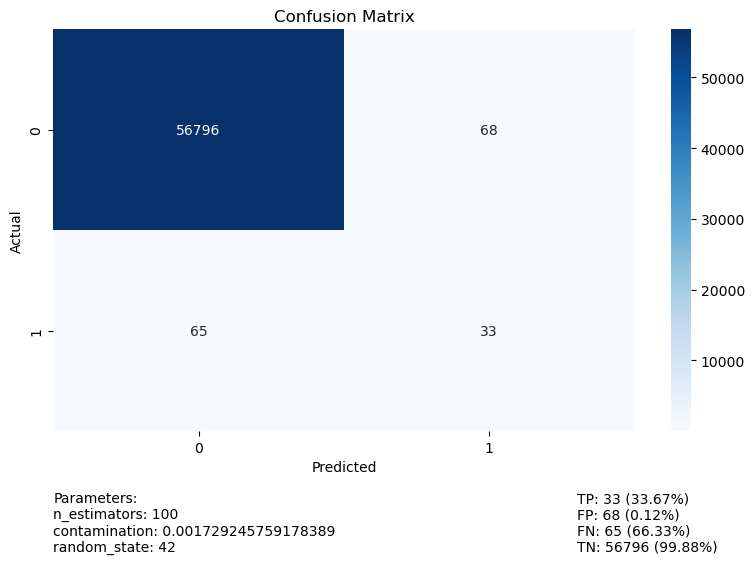

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_val, y_pred, params=None):
    """Plots the confusion matrix with parameters overlaid as text."""

    conf_matrix = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize = (8, 6))
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Parameters Text Box 
    if params:
        
        params_title = "Parameters:\n"
        params_text = "\n".join([f"{key}: {value}" for key, value in params.items()])
       
        # Overlay text on the plot (adjust coordinates as needed)
        plt.text(x = 0, 
                 y = -0.15, 
                 s = params_title + params_text, 
                 ha = 'left',                     # Horizontal Alignment 
                 va = 'top',                      # Vertical Alignment 
                 transform = plt.gca().transAxes, 
                 fontsize = 10) 


    # Calculate stats
    tn, fp, fn, tp = conf_matrix.ravel()  # Flatten the matrix

    # Calculate rates
    tpr = tp / (tp + fn) if (tp+fn) > 0 else 0 # Sensitivity or Recall
    fpr = fp / (fp + tn) if (fp+tn) > 0 else 0 # Fall-out or False Positive Rate
    fnr = fn / (tp + fn) if (tp+fn) > 0 else 0 # Miss Rate or False Negative Rate
    tnr = tn / (tn + fp) if (tn+fp) > 0 else 0 # Specificity or True Negative Rate

    stats_text = (
        f"TP: {tp} ({tpr:.2%})\n"
        f"FP: {fp} ({fpr:.2%})\n"
        f"FN: {fn} ({fnr:.2%})\n"
        f"TN: {tn} ({tnr:.2%})\n"
    )
    
    plt.text(x = 0.9, 
             y = -0.15, 
             s = stats_text, 
             ha = 'left', 
             va = 'top', 
             transform = plt.gca().transAxes, 
             fontsize = 10)

    # Display plot 
    plt.tight_layout() 
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, params)

## Grid Search

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

param_grid = {
    'n_estimators': [20, 30, 40],        # Test different numbers of trees
    'contamination': [0.0017],           # Test around the known fraud rate
    'max_features': [0.4, 0.5, 0.6],     # Consider subsets of features, None uses all
    'max_samples': [0.65, 0.75, 0.85],   # Consider subsets of samples
    'bootstrap': [True, False]           # Sampling w / wo replacement
}

# Instantiate the IsolationForest model
# Keep random_state for consistent results across grid searches
model = IsolationForest(random_state = 42, n_jobs = -1) 



# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'roc_auc',    # Use AUC-ROC as the scoring metric
    cv = 3,                 # 3-fold cross-validation
    n_jobs = -1,            # Use all available cores for parallel processing
    verbose = 1             # Print progress
)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best AUC-ROC score:", grid_search.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/dshebb/miniconda3/envs/dsh-venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'bootstrap': True, 'contamination': 0.0017, 'max_features': 0.5, 'max_samples': 0.65, 'n_estimators': 20}
Best AUC-ROC score: 0.059356050422377904


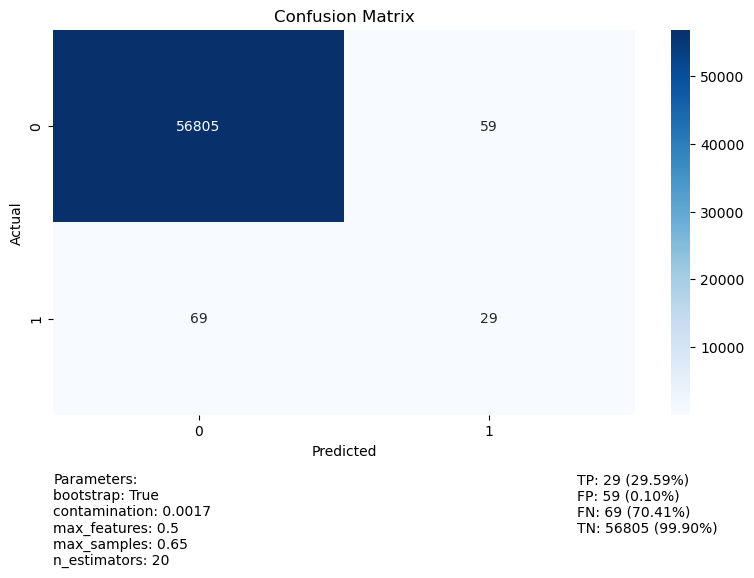

In [57]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_scores = best_model.decision_function(X_test)
y_pred = best_model.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

plot_confusion_matrix(y_test, y_pred, grid_search.best_params_)

## Additional Analysis 

In [74]:
def assemble_test_df(y_true, y_pred, y_pred_scores, transaction_amounts):
    
    """
    Returns:
        A DF with the following columns:
            - y_true
            - y_pred
            - y_pred_scores
            - amount
            - prediction_class
            
        prediction_class contains a label as to whether the prediction was TP, FP, TN, and FN.
    """

    # Confirm input lengths match 
    if len(y_true) != len(y_pred) or len(y_true) != len(transaction_amounts):
        
        print("Inputs Length Mismatch")
        print(f"y_true: {len(y_true)}")
        print(f"y_pred: {len(y_pred)}")
        print(f"transaction_amounts: {len(transaction_amounts)}")
        
        return _  


    # Define function to classify predictions 
    def classify_prediction(row):
        
        if row['y_pred'] == 0:
            if row['y_true'] == 0: return "TN"
            elif row['y_true'] == 1: return "FN"
            
        elif row['y_pred'] == 1:
            if row['y_true'] == 0: return "FP"
            elif row['y_true'] == 1: return "TP"
                
                
    # Create a DataFrame and classify predictions 
    test_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'y_pred_scores': y_pred_scores, 'amount': transaction_amounts})
    test_df['prediction_class'] = test_df.apply(classify_prediction, axis=1)
   
    return test_df


test_df = assemble_test_df(y_test, 
                           y_pred, 
                           y_pred_scores, 
                           X_test_orig['Amount'])

test_df.head()

,y_true,y_pred,y_pred_scores,amount,prediction_class
43428,1,1,-0.116301,364.19,TP
49906,0,0,0.216040,520.12,TN
29474,0,0,0.229118,31.00,TN
276481,0,0,0.217386,1.50,TN
278846,0,0,0.234346,0.89,TN


### Dollar value of detected fraud 

The rates aren't that good, but how do we fare in dollars and cents? 

In [75]:
def calculate_dollar_values(test_df):
    
    # Use groupby to summarize values of different prediction classes
    grouped_df = test_df.groupby('prediction_class')['amount'].agg(['sum', 'mean', 'count']).round(2)
    fn_val = grouped_df.loc["FN", "sum"]
    tp_val = grouped_df.loc["TP", "sum"]
    fraud_pct = ((tp_val / (tp_val + fn_val)) * 100).round(2)

    print(f"Fraud caught: ${tp_val}")
    print(f"Fraud missed: ${fn_val}")
    print(f"Percentage fraud value detected: {fraud_pct}%\n")
    
    print(grouped_df)
    

calculate_dollar_values(test_df)

Fraud caught: $1565.29
Fraud missed: $14513.11
Percentage fraud value detected: 9.74%

                         sum     mean  count
prediction_class                            
FN                  14513.11   210.33     69
FP                  75615.28  1281.61     59
TN                4911172.34    86.46  56805
TP                   1565.29    53.98     29


![](https://i.kym-cdn.com/entries/icons/original/000/021/753/mission_failed_meme.png)

## Analyzing the anomaly scores

In [77]:
def analyze_anomaly_scores(test_df):

    # Use groupby to summarize values of different prediction classes
    grouped_df = test_df.groupby('prediction_class')['y_pred_scores'].agg(['mean', 'count', 'max', 'min']).round(2)
    # fn_val = grouped_df.loc["FN", "sum"]
    # tp_val = grouped_df.loc["TP", "sum"]
    # fraud_pct = ((tp_val / (tp_val + fn_val)) * 100).round(2)

    # print(f"Fraud caught: ${tp_val}")
    # print(f"Fraud missed: ${fn_val}")
    # print(f"Percentage fraud value detected: {fraud_pct}%\n")
    
    print(grouped_df)
    

analyze_anomaly_scores(test_df)

                  mean  count   max   min
prediction_class                         
FN                0.12     69  0.24  0.01
FP               -0.07     59 -0.00 -0.22
TN                0.22  56805  0.25  0.00
TP               -0.10     29 -0.00 -0.25


![|1](https://64.media.tumblr.com/0385317b62a26aec560d9fec21d542c2/4b89ee22a2aa876a-cf/s540x810/ef13d632fb2161c174fb988135aa87fc5d769300.gifv)

/tmp/ipykernel_52578/1505968154.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Show the legend


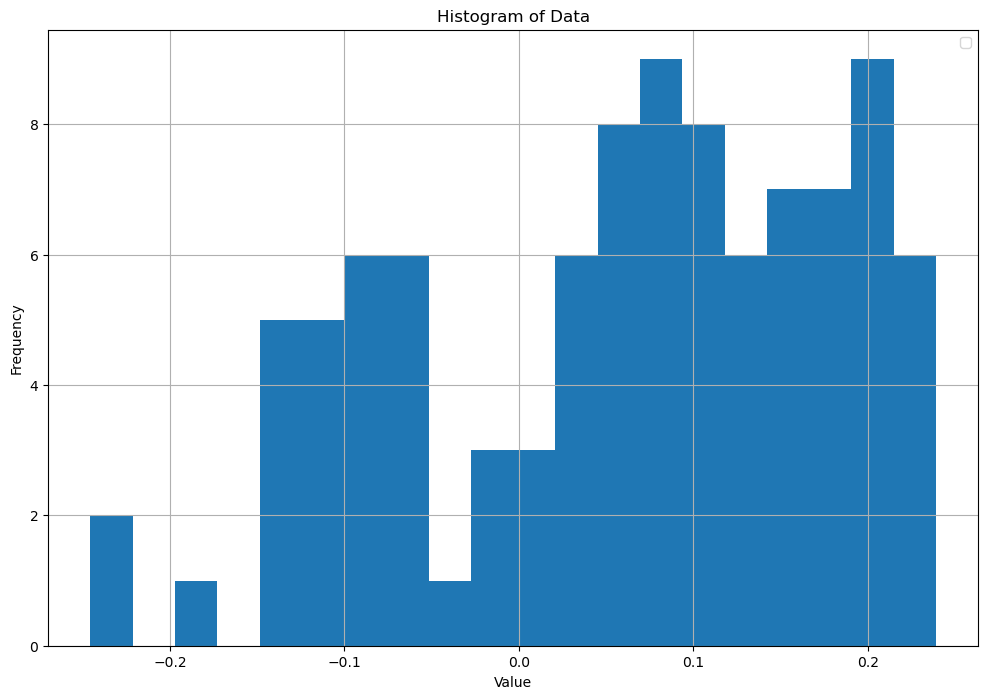

In [93]:
import numpy as np

def plot_pred_score_distribution(test_df):
    
    plt.figure(figsize=(12, 8))

    plt.hist(test_df[test_df["y_true"] == 1]["y_pred_scores"],
             bins = 20)

    # # Calculate max FN value
    # max_fn = test_df[test_df["prediction_class"] == "FN"]["y_pred_scores"].max()

    # chopped_df = test_df[test_df["y_pred_score"] <= max_fn]

    # # Get unique prediction classes (excluding "TN") and create color map
    # prediction_classes = test_df["prediction_class"].unique()
    # colors = plt.cm.get_cmap('viridis', len(prediction_classes))

    # for i, class_name in enumerate(prediction_classes):
    #     class_data = test_df[test_df["prediction_class"] == class_name]["y_pred_scores"]

    #     # Condition for TP values
    #     if class_name == "TP":
    #         class_data = class_data[class_data <= max_fn] #Keep TP values less than max FN

    #     plt.hist(class_data, bins=10, alpha=0.7, label=class_name, color=colors(i))  # Add label and color

    plt.title("Histogram of Data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()  # Show the legend
    plt.show()


plot_pred_score_distribution(test_df)


In [61]:
# Display the outliers
from sklearn.preprocessing import StandardScaler
import umap

# sampled_df = df.sample(n = 100000)
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_test_scaled)

import matplotlib.pyplot as plt 
import seaborn as sns

def umap_scatter_plot(embedding, df_class_column):

    if embedding.ndim == 2 and embedding.shape[1] >= 2:
        
        plt.figure(figsize=(12, 10))
        colours = [sns.color_palette()[x] for x in df_class_column]
                
        plt.scatter(
            x = embedding[:, 0],
            y = embedding[:, 1],
            c = colours,
            s = 1
            )

        plt.gca().set_aspect('equal', 'datalim')
        plt.title('UMAP projection of the fraud dataset', fontsize = 24)
        plt.show()
        
        
    else: 
        print("Error: `embedding` should be a 2-dimensional array with at least 2 columns.")
        
        
print(umap_scatter_plot(embedding, df_test["Outliers"]))
print(umap_scatter_plot(embedding, df_test["Class"]))


ModuleNotFoundError: No module named 'umap'